# Notebook to perform the ML model training
### Included are the changes to be made to the original model as well

In [2]:
import seisbench.models as sbm
import seisbench.generate as sbg
import seisbench.data as sbd

from pathlib import Path
import numpy as np
from seisbench.util import worker_seeding
from torch.utils.data import DataLoader
import pickle
import pandas as pd

import torch
import matplotlib.pyplot as plt
import seisbench
import multiprocessing

In [6]:
''' Parameters
'''
sampling_rate = 100 # Sampling rate in Hz
classes = 1 # Number of classes (P, S and Detection)
in_channels = 1 # Input channels (e.g. HHZ)
phases = 'P' # Phase of interest
benchmark_dataset = 'stead' # Benchmark dataset to initialise the pretrained weights --> You could also use OBS or STEAD
component_order = 'Z' # Order of the components
in_samples = 2601 # Input samples for the model (fixed for all samples)

base_path_data = 'data'

In [3]:
''' Define model
'''
seisbench.use_backup_repository()
delete_target_layers = ['pick_decoders.1.']
target = sbm.EQTransformer(sampling_rate=sampling_rate, classes=classes, in_channels=in_channels, phases=phases)
source = sbm.EQTransformer.from_pretrained(benchmark_dataset)


source_state_dict = source.state_dict()
target_state_dict = target.state_dict()
format_print = "%50s, %30s, %30s, %30s"
# Find the layers to remove, these would correspond to the S class.
print(format_print % ('NAME OF THE LAYER', 'SHAPE OF SOURCE MODEL', 'SHAPE OF TARGET MODEL', 'MATCH BETWEEN SHAPES'))
for key in source_state_dict.keys():
    try: 
        print(format_print % (key, source_state_dict[key].shape, target_state_dict[key].shape, source_state_dict[key].shape ==target_state_dict[key].shape) )
    except:
        print(format_print % (key, source_state_dict[key].shape, 'NOT PRESENT IN TARGET MODEL', '-') )

2024-10-06 13:50:43,776 | seisbench | WARNING | Setting remote root to: https://seisbench.gfz-potsdam.de/mirror/
Please note that this can affect your download speed.


                                 NAME OF THE LAYER,          SHAPE OF SOURCE MODEL,          SHAPE OF TARGET MODEL,           MATCH BETWEEN SHAPES
                            encoder.convs.0.weight,         torch.Size([8, 3, 11]),         torch.Size([8, 1, 11]),                          False
                              encoder.convs.0.bias,                torch.Size([8]),                torch.Size([8]),                           True
                            encoder.convs.1.weight,         torch.Size([16, 8, 9]),         torch.Size([16, 8, 9]),                           True
                              encoder.convs.1.bias,               torch.Size([16]),               torch.Size([16]),                           True
                            encoder.convs.2.weight,        torch.Size([16, 16, 7]),        torch.Size([16, 16, 7]),                           True
                              encoder.convs.2.bias,               torch.Size([16]),               torch.Size([16]),   

/home/visitor_cp1/miniconda3/lib/python3.12/site-packages/seisbench/models/base.py:489: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(f"{path_pt}"

In [4]:
# The first step would be to get rid of all layers which are not present in the TARGET model
keys_to_delete = [key for key in source_state_dict.keys() if key not in target_state_dict]
for key in keys_to_delete:
    source_state_dict.pop(key)
    print(f'Layer {key} deleted successfully.')
print(f'\n Layers of target and source models are the same: {source_state_dict.keys() == target_state_dict.keys()}')

Layer pick_lstms.1.weight_ih_l0 deleted successfully.
Layer pick_lstms.1.weight_hh_l0 deleted successfully.
Layer pick_lstms.1.bias_ih_l0 deleted successfully.
Layer pick_lstms.1.bias_hh_l0 deleted successfully.
Layer pick_attentions.1.Wx deleted successfully.
Layer pick_attentions.1.Wt deleted successfully.
Layer pick_attentions.1.bh deleted successfully.
Layer pick_attentions.1.Wa deleted successfully.
Layer pick_attentions.1.ba deleted successfully.
Layer pick_decoders.1.convs.0.weight deleted successfully.
Layer pick_decoders.1.convs.0.bias deleted successfully.
Layer pick_decoders.1.convs.1.weight deleted successfully.
Layer pick_decoders.1.convs.1.bias deleted successfully.
Layer pick_decoders.1.convs.2.weight deleted successfully.
Layer pick_decoders.1.convs.2.bias deleted successfully.
Layer pick_decoders.1.convs.3.weight deleted successfully.
Layer pick_decoders.1.convs.3.bias deleted successfully.
Layer pick_decoders.1.convs.4.weight deleted successfully.
Layer pick_decoders.

In [5]:
# The second step would be to change the input convolution layer, one channel instead o three.
# What channel to keep, E, N or Z? What their corresponding index is, 0, 1  and 2?
newsize = torch.Size([8, 1, 11])
reshaped_source_state_dict = source_state_dict.copy()
first_channels_to_drop = 2
reshaped_source_state_dict['encoder.convs.0.weight'] = reshaped_source_state_dict['encoder.convs.0.weight'][:, first_channels_to_drop:, :] # Drop two of three channels, the first twos which correspond E and N components.
print(f"Shape of the original input layer (3 channels): {source_state_dict['encoder.convs.0.weight'].shape}")
print(f"Shape of the reshaped input layer (1 channel): {reshaped_source_state_dict['encoder.convs.0.weight'].shape}")

Shape of the original input layer (3 channels): torch.Size([8, 3, 11])
Shape of the reshaped input layer (1 channel): torch.Size([8, 1, 11])


In [6]:
# Save the pretrained weights
save_path = base_path_data
torch.save(reshaped_source_state_dict, 'stead_pretrained_weights.pt')

In [7]:
# Load the model with pretrained weights and apply transfer learning using whale calls in the last layer
# You can chose to set in_Samples to 2201 or to 4601. The first option would use only the existing data but the second one will complete the short waveforms by padding with 0s.
# I think padding with 0s in a signficant part of the waveform may not be realistic and introduce bias to the training data, so I choose to work with the samllest length of the training data, which is 2201.
model = sbm.EQTransformer(in_channels=in_channels, classes=classes, phases=phases, sampling_rate=sampling_rate, in_samples=in_samples) 
model.load_state_dict(torch.load('stead_pretrained_weights.pt')); # Load pretrained weights
format_print = "%10i, %50s, %30s"
# Define the layer(s) for transfer learning
state_dict = model.state_dict()
print(format_print % (0, 'NAME OF THE LAYER', 'SHAPE OF SOURCE MODEL'))
for i, key in enumerate(state_dict.keys()):
    print(format_print % (i, key, state_dict[key].shape))

/tmp/ipykernel_2274539/1340543111.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('stead_pretrained_weights.pt')); # Load pretrained wei

         0,                                  NAME OF THE LAYER,          SHAPE OF SOURCE MODEL
         0,                             encoder.convs.0.weight,         torch.Size([8, 1, 11])
         1,                               encoder.convs.0.bias,                torch.Size([8])
         2,                             encoder.convs.1.weight,         torch.Size([16, 8, 9])
         3,                               encoder.convs.1.bias,               torch.Size([16])
         4,                             encoder.convs.2.weight,        torch.Size([16, 16, 7])
         5,                               encoder.convs.2.bias,               torch.Size([16])
         6,                             encoder.convs.3.weight,        torch.Size([32, 16, 7])
         7,                               encoder.convs.3.bias,               torch.Size([32])
         8,                             encoder.convs.4.weight,        torch.Size([32, 32, 5])
         9,                               encoder.

In [3]:
base_path_data = 'data/augmentation_data'

In [7]:
def load_data(sampling_rate:int, component_order:str, base_path=Path('.')):
    ''' Loads the training data written in Seisbench format.

    Parameters
        base_path (str): Path of the seisbench data (It is recommended to locate it in the same workspace folder).
        sampling_rate (int): Sampling rate of the data and the training.
        component_order (str): Order of the components.
    Returns
        Tuple[Dataset, Dataset, Dataset]: A tuple containing Training, development and test datasets that will be used for training of the Seisbench model.
    '''
    data = sbd.WaveformDataset(base_path, sampling_rate = sampling_rate, component_order=component_order)
    train, dev, test = data.train_dev_test()
    return train, dev, test

In [8]:
[train, dev, test] = load_data(sampling_rate=sampling_rate, component_order=component_order)

In [9]:
print(len(train))
print(len(dev))
print(len(test))

756895
44511
88808


In [11]:
def create_augmentations(train, dev, test):
    phase_dict = {
        'trace_P_1_arrival_sample': "P",
        'trace_P_2_arrival_sample': "P",
    }
    # Here I add the augmentations recommended to train the EQTransformer model.

    train_generator = sbg.GenericGenerator(train)
    dev_generator = sbg.GenericGenerator(dev)
    test_generator = sbg.GenericGenerator(test)
    sample_boundaries=[None, None]
    detection_fixed_window=4/(1/sampling_rate) # seconds/delta original is 9
    p_phases = [key for key, val in phase_dict.items() if val == 'P']

    augmentations = [
        # Take a random window from the whole waveform
        #sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=model.in_samples*3, windowlen=model.in_samples*4, selection="random", strategy="variable"),
        sbg.RandomWindow(windowlen=model.in_samples, strategy="pad"),
        # Normalize the data
        sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
        # Change the type of the numbers
        sbg.ChangeDtype(np.float32),
        # Create a probabilistic labeller, it takes the input pick and transform it into a triangle so that pick could be found in a window of time instead of in a single point.
        sbg.ProbabilisticLabeller(label_columns=phase_dict, sigma=20, dim=0),   # you can change sigma
        # Create a detection labeller having a fixed window time. Since we seek to find detections, this is a very important parameter.
        sbg.DetectionLabeller(fixed_window=detection_fixed_window, p_phases=p_phases, key=('X', 'detections'), p_time_before=int(.1 / (1/sampling_rate))),
    ]

    train_generator.add_augmentations(augmentations)
    dev_generator.add_augmentations(augmentations)
    test_generator.add_augmentations(augmentations)
    
    return train_generator, dev_generator, test_generator 

In [12]:
# create generators for the augmentations
[train_generator, dev_generator, test_generator] = create_augmentations(train, dev, test)

In [13]:
def plot_augmented_data(number_plots):
    
    for i in range(number_plots):
        gen = train_generator
        sample = gen[np.random.randint(len(gen))]

        fig = plt.figure(figsize=(15, 10))
        axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
        axs[0].plot(sample["X"].T, label='Waveform')
        axs[1].plot(sample["y"][0].T, label='P prediction')
        axs[1].plot(sample["y"][1].T, label='Ruido')
        axs[1].plot(sample["detections"].T, label='Detection')
        axs[1].legend()
        axs[0].legend()
        plt.show()

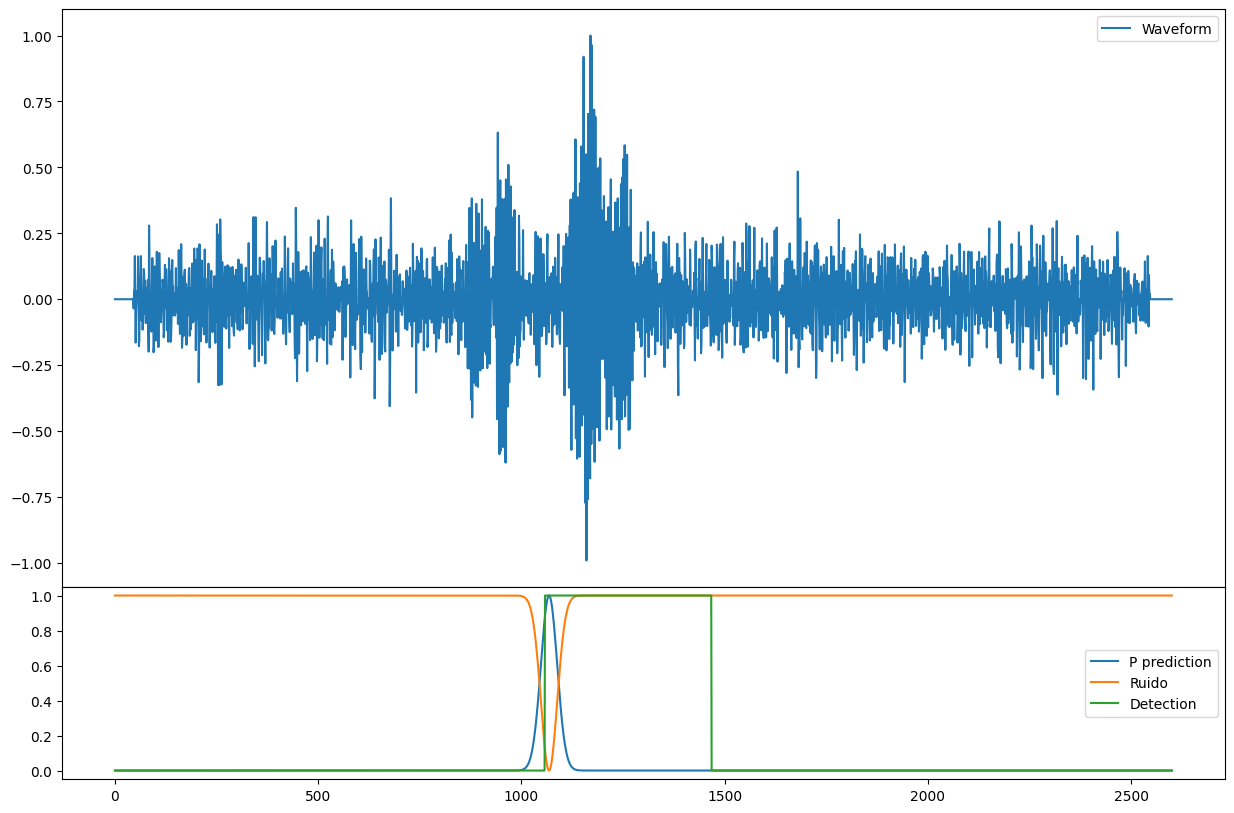

In [14]:
# plot an example of augmented data to check the result of augmentations
plot_augmented_data(1)

In [15]:
# Pass the data to the Pytorch data loader, which will automatically handle parallel processing and batching
# Creates two loaders, one for training and another for validation
def create_data_loaders(batch_size, num_workers):
    train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding, 
                             persistent_workers=False)
    dev_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding,
                           persistent_workers=False)
    test_loader = DataLoader(test_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding,
                             persistent_workers=False)
    
    return train_loader, dev_loader, test_loader

In [16]:
num_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores: {num_cores}")

num_workers_ = num_cores; batch_size_ = 2**8
[train_loader, dev_loader, test_loader] = create_data_loaders(batch_size = batch_size_, num_workers = num_workers_)

Number of CPU cores: 160


In [17]:
# The smaller the learning rate, the more processing time. Find an appropriate learning rate.
# Here we load the optimizer and Loss functions.

learning_rate = 1e-3   # you can change this
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss = torch.nn.BCELoss()

def loss_fn(y_pred, batch, loss_weights, eps=1e-5):

    p_true = batch['y'][:,0]
    det_true = batch['detections'][:,0]
    p_pred = y_pred[:,0]
    det_pred = y_pred[:,1]
    
    # vector binary cross entropy loss
    return (loss_weights[0]*loss(input=det_pred.float(), target=det_true.float()) + 
            loss_weights[1]*loss(input=p_pred.float(), target=p_true.float()) )

In [18]:
# Functions that calculate sthe accuracy of the training
# This depends upon the given threshold for the peaks
def calc_acc(pred,batch, loss_weights):
    
    # Simple accuracy measure in % taking into account all samples of all training signals
    p_true = batch['y'][:,0] # Torch tensor of size (Nbatch, Nsamples)
    det_true = batch['detections'][:,0]
    p_pred = pred[:,0]
    det_pred = pred[:,1]
    
    p_max = torch.max(p_pred,1).values.unsqueeze(1)
    thr_det = 0.5

    p_pred = (p_pred >= thr_det).float()

    det_pred = (det_pred > thr_det).float()
    
    acc_p = (p_pred == p_true).float().sum()
    acc_det = (det_pred == det_true).float().sum()
    
    acc_p = (100 * acc_p / torch.numel(p_pred)).numpy()
    acc_det = (100 * acc_det / torch.numel(det_pred)).numpy()
    
    acc = (loss_weights[0]*acc_det) + (loss_weights[1]*acc_p)
    return acc

In [19]:
# Loop for the training
def train_loop(dataloader, loss_weights):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    loss_cum = 0
    acc_cum = 0
    for batch_id, batch in enumerate(dataloader):
        
        # Compute prediction and loss
        pred = model(batch["X"].to(model.device))
        # converting the default tuple output in a Tensor
        tensor_all = []
        stack_ = torch.stack([pred[0], pred[1]])
        for j in range(len(stack_[0])):
            tensor_current = torch.stack([stack_[0][j], stack_[1][j]])
            tensor_all.append(tensor_current)
        tensor_all = torch.stack(tensor_all)
            
        #
        
        loss = loss_fn(tensor_all, batch, loss_weights)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_id % 5 == 0:
            acc = calc_acc(tensor_all,batch, loss_weights)
            loss, current = loss.item(), batch_id * batch["X"].shape[0]
            print(f"loss: {loss:>7f}, accuracy: {acc:>.3f}%, batch [{current:>5d}/{size:>5d}]")
            
        loss_cum += loss
        acc_cum += acc
        
    loss_cum /= num_batches
    acc_cum /= num_batches
        
    return loss_cum, acc_cum


def val_loop(dataloader, loss_weights):
    num_batches = len(dataloader)
    test_loss = 0
    test_acc = 0

    with torch.no_grad():
        for batch in dataloader:

            pred = model(batch["X"].to(model.device))
            
            # converting the default tuple output in a Tensor
            tensor_all = []
            stack_ = torch.stack([pred[0], pred[1]])
            for j in range(len(stack_[0])):
                tensor_current = torch.stack([stack_[0][j], stack_[1][j]])
                tensor_all.append(tensor_current)
            tensor_all = torch.stack(tensor_all)
            

            #
            test_loss += loss_fn(tensor_all, batch, loss_weights).item()
            test_acc += calc_acc(tensor_all,batch, loss_weights)

    test_loss /= num_batches
    test_acc /= num_batches
    
    print(f"Test avg loss: {test_loss:>8f}, test avg accuracy: {test_acc:>.3f}% \n")
    
    return np.round(test_loss,6), test_acc

In [20]:
trainable_layers_detection = [

'encoder.convs.0.weight', # encoder
'encoder.convs.0.bias',
'encoder.convs.1.weight',
'encoder.convs.1.bias',
'encoder.convs.2.weight',
'encoder.convs.2.bias',
'encoder.convs.3.weight',
'encoder.convs.3.bias',
'encoder.convs.4.weight',
'encoder.convs.4.bias',
'encoder.convs.5.weight',
'encoder.convs.5.bias',
'encoder.convs.6.weight',
'encoder.convs.6.bias',

'res_cnn_stack.members.0.norm1.weight',  # res-cnn - member 0
'res_cnn_stack.members.0.norm1.bias',
'res_cnn_stack.members.0.conv1.weight',
'res_cnn_stack.members.0.conv1.bias',
'res_cnn_stack.members.0.norm2.weight',
'res_cnn_stack.members.0.norm2.bias',
'res_cnn_stack.members.0.conv2.weight',
'res_cnn_stack.members.0.conv2.bias',

'res_cnn_stack.members.1.norm1.weight', # res-cnn - member 1
'res_cnn_stack.members.1.norm1.bias',
'res_cnn_stack.members.1.conv1.weight',
'res_cnn_stack.members.1.conv1.bias',
'res_cnn_stack.members.1.norm2.weight',
'res_cnn_stack.members.1.norm2.bias',
'res_cnn_stack.members.1.conv2.weight',
'res_cnn_stack.members.1.conv2.bias',

'res_cnn_stack.members.2.norm1.weight', # res-cnn - member 2
'res_cnn_stack.members.2.norm1.bias',
'res_cnn_stack.members.2.conv1.weight',
'res_cnn_stack.members.2.conv1.bias',
'res_cnn_stack.members.2.norm2.weight',
'res_cnn_stack.members.2.norm2.bias',
'res_cnn_stack.members.2.conv2.weight',
'res_cnn_stack.members.2.conv2.bias',

'res_cnn_stack.members.3.norm1.weight', # res-cnn -member 3
'res_cnn_stack.members.3.norm1.bias',
'res_cnn_stack.members.3.conv1.weight',
'res_cnn_stack.members.3.conv1.bias',
'res_cnn_stack.members.3.norm2.weight',
'res_cnn_stack.members.3.norm2.bias',
'res_cnn_stack.members.3.conv2.weight',
'res_cnn_stack.members.3.conv2.bias',


'res_cnn_stack.members.4.norm1.weight', # res-cnn - member 4
'res_cnn_stack.members.4.norm1.bias',
'res_cnn_stack.members.4.conv1.weight',
'res_cnn_stack.members.4.conv1.bias',
'res_cnn_stack.members.4.norm2.weight',
'res_cnn_stack.members.4.norm2.bias',
'res_cnn_stack.members.4.conv2.weight',
'res_cnn_stack.members.4.conv2.bias',

'res_cnn_stack.members.5.norm1.weight', # res-cnn - member 5
'res_cnn_stack.members.5.norm1.bias',
'res_cnn_stack.members.5.conv1.weight',
'res_cnn_stack.members.5.conv1.bias',
'res_cnn_stack.members.5.norm2.weight',
'res_cnn_stack.members.5.norm2.bias',
'res_cnn_stack.members.5.conv2.weight',
'res_cnn_stack.members.5.conv2.bias',

'res_cnn_stack.members.6.norm1.weight', # res_cnn - member 6
'res_cnn_stack.members.6.norm1.bias',
'res_cnn_stack.members.6.conv1.weight',
'res_cnn_stack.members.6.conv1.bias',
'res_cnn_stack.members.6.norm2.weight',
'res_cnn_stack.members.6.norm2.bias',
'res_cnn_stack.members.6.conv2.weight',
'res_cnn_stack.members.6.conv2.bias',


'bi_lstm_stack.members.0.lstm.weight_ih_l0', # bi-lstm - member 0
'bi_lstm_stack.members.0.lstm.weight_hh_l0',
'bi_lstm_stack.members.0.lstm.bias_ih_l0',
'bi_lstm_stack.members.0.lstm.bias_hh_l0',
'bi_lstm_stack.members.0.lstm.weight_ih_l0_reverse',
'bi_lstm_stack.members.0.lstm.weight_hh_l0_reverse',
'bi_lstm_stack.members.0.lstm.bias_ih_l0_reverse',
'bi_lstm_stack.members.0.lstm.bias_hh_l0_reverse',
'bi_lstm_stack.members.0.conv.weight',
'bi_lstm_stack.members.0.conv.bias',
'bi_lstm_stack.members.0.norm.weight',
'bi_lstm_stack.members.0.norm.bias',

'bi_lstm_stack.members.1.lstm.weight_ih_l0', # bi-lstm - member 1 
'bi_lstm_stack.members.1.lstm.weight_hh_l0',
'bi_lstm_stack.members.1.lstm.bias_ih_l0',
'bi_lstm_stack.members.1.lstm.bias_hh_l0',
'bi_lstm_stack.members.1.lstm.weight_ih_l0_reverse',
'bi_lstm_stack.members.1.lstm.weight_hh_l0_reverse',
'bi_lstm_stack.members.1.lstm.bias_ih_l0_reverse',
'bi_lstm_stack.members.1.lstm.bias_hh_l0_reverse',
'bi_lstm_stack.members.1.conv.weight',
'bi_lstm_stack.members.1.conv.bias',
'bi_lstm_stack.members.1.norm.weight',
'bi_lstm_stack.members.1.norm.bias',

'bi_lstm_stack.members.2.lstm.weight_ih_l0', # bi/lstm - member 2
'bi_lstm_stack.members.2.lstm.weight_hh_l0',
'bi_lstm_stack.members.2.lstm.bias_ih_l0',
'bi_lstm_stack.members.2.lstm.bias_hh_l0',
'bi_lstm_stack.members.2.lstm.weight_ih_l0_reverse',
'bi_lstm_stack.members.2.lstm.weight_hh_l0_reverse',
'bi_lstm_stack.members.2.lstm.bias_ih_l0_reverse',
'bi_lstm_stack.members.2.lstm.bias_hh_l0_reverse',
'bi_lstm_stack.members.2.conv.weight',
'bi_lstm_stack.members.2.conv.bias',
'bi_lstm_stack.members.2.norm.weight',
 'bi_lstm_stack.members.2.norm.bias',
  
  'transformer_d0.attention.Wx', # Global attention - Detections and Picks
'transformer_d0.attention.Wt',
'transformer_d0.attention.bh',
'transformer_d0.attention.Wa',
'transformer_d0.attention.ba',
'transformer_d0.norm1.gamma',
'transformer_d0.norm1.beta',
'transformer_d0.ff.lin1.weight',
'transformer_d0.ff.lin1.bias',
'transformer_d0.ff.lin2.weight',
'transformer_d0.ff.lin2.bias',
'transformer_d0.norm2.gamma',
'transformer_d0.norm2.beta',


  'transformer_d.attention.Wx', # Global attention for the detection.
 'transformer_d.attention.Wt',
 'transformer_d.attention.bh',
 'transformer_d.attention.Wa',
 'transformer_d.attention.ba',
 'transformer_d.norm1.gamma',
 'transformer_d.norm1.beta',
 'transformer_d.ff.lin1.weight',
 'transformer_d.ff.lin1.bias',
 'transformer_d.ff.lin2.weight',
 'transformer_d.ff.lin2.bias',
 'transformer_d.norm2.gamma',
 'transformer_d.norm2.beta',

  '', # There is no local attention for detection
'',
'',
'',
'',

'', # there is no LSTM block for detection
'',
'',
'',


'decoder_d.convs.0.weight', # Decoders - Last 8 layers (0r 16)
'decoder_d.convs.0.bias',
'decoder_d.convs.1.weight',
'decoder_d.convs.1.bias',
'decoder_d.convs.2.weight',
'decoder_d.convs.2.bias',
'decoder_d.convs.3.weight',
'decoder_d.convs.3.bias',
'decoder_d.convs.4.weight',
'decoder_d.convs.4.bias',
'decoder_d.convs.5.weight',
'decoder_d.convs.5.bias',
'decoder_d.convs.6.weight',
'decoder_d.convs.6.bias',
'conv_d.weight',
'conv_d.bias',




]

trainable_layers_P_pick = [
 
     '', # encoder
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
 
     '', # res_cnn - member 0
  '',
  '',
  '',
  '',
  '',
  '',
  '',
 
    '', # res_cnn - member 1
  '',
  '',
  '',
  '',
  '',
  '',
  '',
 
   '', # res_cnn - member 2
  '',
  '',
  '',
  '',
  '',
  '',
  '',

  '', # res_cnn - member 3
  '',
  '',
  '',
  '',
  '',
  '',
  '',

  '', # res_cnn - member 4
  '',
  '',
  '',
  '',
  '',
  '',
  '',

  '', # res_cnn - member 5
  '',
  '',
  '',
  '',
  '',
  '',
  '',

  '', # res_cnn - member 6
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  

  '', # bi-lstm - member 0
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  
  '', # bi-lstm - member 1
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  
  '', # bi-lstm - member 2
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',


  '', # Global attention  - Detection and picks
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',

  '', # Global attention for the detection.
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',

  'pick_lstms.0.weight_ih_l0', # LSTM block - Last 17 layers (4 more for LSTM and 5 more for local attention)
  'pick_lstms.0.weight_hh_l0',
  'pick_lstms.0.bias_ih_l0',
  'pick_lstms.0.bias_hh_l0',
  
  'pick_attentions.0.Wx', # local attention to P pick - Last 13 layers (5 more for local attention)
  'pick_attentions.0.Wt',
  'pick_attentions.0.bh',
  'pick_attentions.0.Wa',
  'pick_attentions.0.ba',


  'pick_decoders.0.convs.0.weight', # Decoders - Last 8 layers (0r 16)
  'pick_decoders.0.convs.0.bias',
  'pick_decoders.0.convs.1.weight',
  'pick_decoders.0.convs.1.bias',
  'pick_decoders.0.convs.2.weight',
  'pick_decoders.0.convs.2.bias',
  'pick_decoders.0.convs.3.weight',
  'pick_decoders.0.convs.3.bias',
  'pick_decoders.0.convs.4.weight',
  'pick_decoders.0.convs.4.bias',
  'pick_decoders.0.convs.5.weight',
  'pick_decoders.0.convs.5.bias',
  'pick_decoders.0.convs.6.weight',
  'pick_decoders.0.convs.6.bias',
  'pick_convs.0.weight',
  'pick_convs.0.bias',

  

  
]

In [21]:
# Make the last layers trainable (require_grad) and freeze the previous ones.
# last_layer = 8  ################ CHANGE THIS ###################
last_layer =157  ################ CHANGE THIS ################### 
format_print = "%5i %50s %15s"
#target_P_layers = trainable_layers_P_pi1|ck[-last_layer*2:]
target_P_layers = trainable_layers_P_pick[-last_layer:]
print(target_P_layers)
#target_Detection_layers = trainable_layers_detection[-last_layer*2:]
target_Detection_layers = trainable_layers_detection[-last_layer:]
print(target_Detection_layers)
print("%5s %50s %15s" % ('INDEX', 'LAYER', 'TRAINABLE'))
for i, (name, param) in enumerate(model.named_parameters()):
    if name in target_P_layers or name in target_Detection_layers:
        param.requires_grad = True
    else:
        param.requires_grad = False
    print(format_print % (i, name, param.requires_grad))

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'pick_lstms.0.weight_ih_l0', 'pick_lstms.0.weight_hh_l0', 'pick_lstms.0.bias_ih_l0', 'pick_lstms.0.bias_hh_l0', 'pick_attentions.0.Wx', 'pick_attentions.0.Wt', 'pick_attentions.0.bh', 'pick_attentions.0.Wa', 'pick_attentions.0.ba', 'pick_decoders.0.convs.0.weight', 'pick_decoders.0.convs.0.bias', 'pick_decoders.0.convs.1.weight', 'pick_decoders.0.convs.1.bias', 'pick_decoders.0.convs.2.weight', 'pick_decoders.0.convs.2.bias', 'pick_decoders.0.convs.3.weight', 'pick_d

In [22]:
# Function to execute the training.
import gc

def exec_train(thr_epochs, loss_weights, train_loader, dev_loader, test_loader, path_weights, model, path_stats, last_layers):
    
    df_info = pd.DataFrame()
    df_info['Detection weight'] = loss_weights[0]
    df_info['P weight'] = loss_weights[1]
    df_info['Learning rate'] = learning_rate

    count = 0
    t = 105
    min_val_loss = 100

    # IN case the process is stopped and you need to resume the last point of the training.
    best_val_loss = [0, 0]
    if t == 0:
        val_loss_ls = []
        val_acc_ls = []
        epoch_ls = []
        train_loss_ls = []
        train_acc_ls = []
        test_loss_ls = []
        test_acc_ls = []
    else:
        # Path to your pickle file
        file_name = 'stats.pkl'
        
        # Open the file in read-binary ('rb') mode
        with open(file_name, 'rb') as file:
            data = pickle.load(file)
        epoch_ls, train_loss_ls, train_acc_ls, val_loss_ls, val_acc_ls, test_loss_ls, test_acc_ls = data
        model.load_state_dict(torch.load(f'ep105_wc_weights.pt')) # CHANGE THIS EACH TIME YOU RERUN THE CODE
        min_val_loss = np.min(val_loss_ls)
        
        
    

    while count!=thr_epochs:
        
        t += 1
        print(f'Epoch {t}\n------------------------')
        [train_loss, train_acc] = train_loop(train_loader, loss_weights) # train metrics

        # Validation loop with no tracking gradient
        with torch.no_grad():
            [val_loss, val_acc] = val_loop(dev_loader, loss_weights) # test metrics
            [test_loss, test_acc] = val_loop(test_loader, loss_weights) # test metrics

        # epochs
        epoch_ls.append(t)
        # train
        train_loss_ls.append(train_loss)
        train_acc_ls.append(train_acc)
        # validation
        val_loss_ls.append(val_loss)
        val_acc_ls.append(val_acc)
        # test
        test_loss_ls.append(test_loss)
        test_acc_ls.append(test_acc)

        if val_loss<min_val_loss:  # intiialize the best loss
            min_val_loss = val_loss
            print('---------------------------------------------- BEST LOSS: {} ------------------------------------'.format(min_val_loss))
            count = 0
            # Save the weights locally for the best model
            torch.save(model.state_dict(), f'ep{str(t)}_' + path_weights)
            best_val_loss[0] = t
            best_val_loss[1] = min_val_loss
        else:
            count += 1

        torch.save(model.state_dict(), f'temp_ep{str(t)}' + path_weights)

        stats_ls = [epoch_ls, train_loss_ls, train_acc_ls, val_loss_ls, val_acc_ls, test_loss_ls, test_acc_ls]
        with open(path_stats, "wb") as open_file:
            pickle.dump(stats_ls, open_file)

        # Clear large variables and invoke garbage collection
        del train_loss, train_acc, val_loss, val_acc, test_loss, test_acc
        gc.collect()
        
        #file_name = path_stats
        #open_file = open(file_name, "wb")
        #pickle.dump(stats_ls, open_file)
        #open_file.close()

    df_info['Epochs'] = best_val_loss[0]
    df_info['Best validation loss'] = best_val_loss[1]
    df_info['Trained last layers'] = last_layers
    df_info.to_excel(path_weights.replace('pt', 'xlsx'))
        
    return epoch_ls, train_loss_ls, train_acc_ls, val_loss_ls, val_acc_ls, test_loss_ls, test_acc_ls

In [23]:
run = True
if run:
    path = 'wc_weights.pt'
    exec_train(thr_epochs=12, loss_weights=[0.9,0.1], train_loader=train_loader, dev_loader=dev_loader, 
            test_loader=test_loader, path_weights=path, model=model, 
            path_stats='stats.pkl', last_layers = last_layer)

Epoch 106
------------------------


/home/visitor_cp1/miniconda3/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
/tmp/ipykernel

loss: 0.025799, accuracy: 92.884%, batch [    0/756895]
loss: 0.019449, accuracy: 93.053%, batch [ 1280/756895]
loss: 0.021125, accuracy: 92.946%, batch [ 2560/756895]
loss: 0.017635, accuracy: 93.123%, batch [ 3840/756895]
loss: 0.016663, accuracy: 93.076%, batch [ 5120/756895]
loss: 0.020072, accuracy: 93.009%, batch [ 6400/756895]
loss: 0.017334, accuracy: 93.054%, batch [ 7680/756895]
loss: 0.017064, accuracy: 93.080%, batch [ 8960/756895]
loss: 0.020432, accuracy: 92.960%, batch [10240/756895]
loss: 0.016315, accuracy: 93.336%, batch [11520/756895]
loss: 0.016713, accuracy: 93.187%, batch [12800/756895]
loss: 0.019909, accuracy: 93.120%, batch [14080/756895]
loss: 0.015742, accuracy: 93.078%, batch [15360/756895]
loss: 0.018793, accuracy: 92.941%, batch [16640/756895]
loss: 0.019152, accuracy: 92.974%, batch [17920/756895]
loss: 0.019002, accuracy: 93.155%, batch [19200/756895]
loss: 0.016205, accuracy: 93.203%, batch [20480/756895]
loss: 0.015827, accuracy: 93.284%, batch [21760/

ModuleNotFoundError: No module named 'openpyxl'